In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dataframe_image as dfi
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.optimize import differential_evolution
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("data_optimized.csv")
df.drop(columns="result", inplace=True)
df.columns

In [ ]:
signal_period = 1000000 / 30

df["Clock Period Utilization"] = ( ( df["Clock Period (ns)"] - df["WNS (ns)"]) / df["Clock Period (ns)"] ) * 100
df["Cycle Utilization"] = ( ( df["Clock Period (ns)"] * df["Cycles"] ) / signal_period ) * 100
df["Time Utilization"] = df["Clock Period Utilization"] * df["Cycle Utilization"]

In [ ]:
independant_variables = [
    "Clock Period (ns)", "Cycles", "Frace Width", "Num Parallel", "Int Bits", "D", "H"
]

dependant variables = [
    "Clock Period Utilization", "Cycle Utilization", "Time Utilization",
    "WNS (ns)", "LUTs", "Registers", "BRAMs", "DSPs", "Total Power (W)", 
    "Dynamic Power (W)", "Static Power (W)", "MAE", "RMSE", "Execution Time (m)"
]

In [4]:
chunk_size = 20  # number of rows per image

for i in range(0, len(df), chunk_size):
    chunk = df.iloc[i:i+chunk_size]
    dfi.export(chunk, f"df_chunk_{i}.png", table_conversion='chrome')

df

,LUTs,Registers,BRAMs,DSPs,WNS (ns),Total Power (W),Dynamic Power (W),Static Power (W),d,h,INT_WIDTH,FRAC_WIDTH,MAE,RMSE,Execution Time (m)
2,356963,640,0,3888,9.463,2.964,0.019,2.945,64,16,6,14,0.009261,0.013363,32.263611
3,95009,480,0,3888,9.291,2.961,0.016,2.945,64,16,6,9,0.009564,0.013729,18.589260
4,418852,320,0,0,9.221,2.950,0.005,2.944,64,16,6,4,0.089903,0.129848,18.572373
7,218944,640,0,2352,9.247,2.962,0.018,2.945,32,16,6,14,0.009434,0.013792,18.855132
8,59722,480,0,2352,9.365,2.959,0.014,2.945,32,16,6,9,0.009738,0.014050,12.050908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,11808,240,0,432,9.311,2.987,0.042,2.945,4,4,6,24,0.005595,0.008109,4.584516
121,6523,200,0,216,9.331,2.959,0.014,2.945,4,4,6,19,0.005595,0.008109,2.951785
122,11477,160,0,108,9.422,2.948,0.004,2.944,4,4,6,14,0.005600,0.008118,2.744606
123,3916,120,0,108,9.236,2.948,0.003,2.944,4,4,6,9,0.005932,0.008603,2.463717


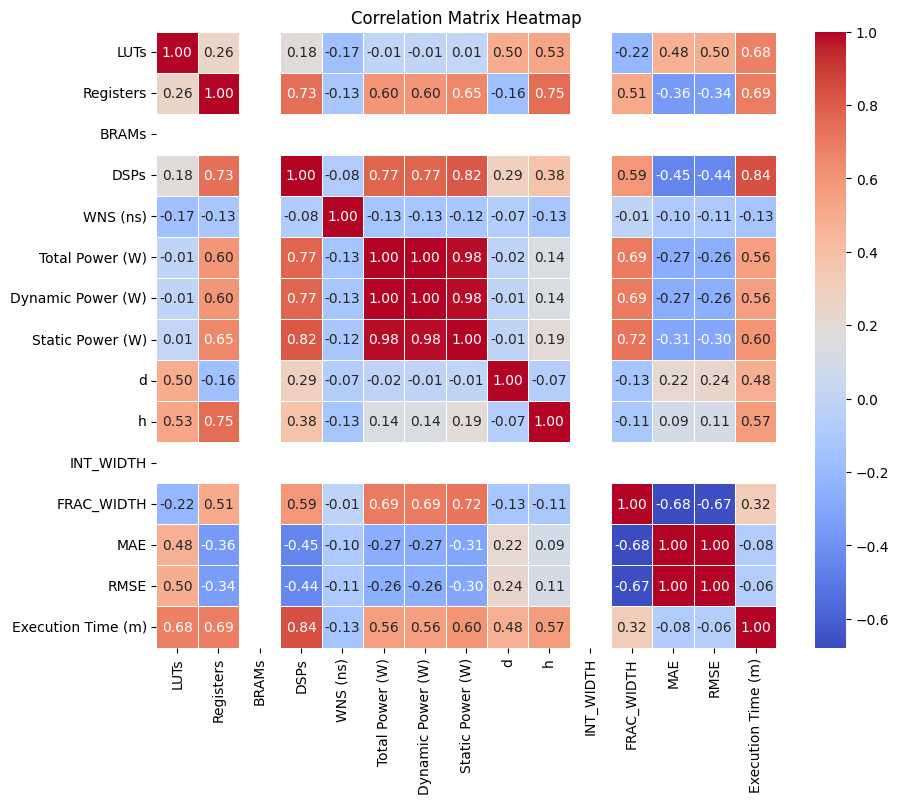

<Figure size 640x480 with 0 Axes>

In [5]:
corr = df.corr()

# Set up the plot
plt.figure(figsize=(10, 8))

# Plot the heatmap
sns.heatmap(
    corr,
    annot=True,          # show correlation values
    fmt=".2f",           # format numbers
    cmap="coolwarm",     # color palette
    linewidths=0.5
)

plt.title("Correlation Matrix Heatmap")
plt.show()
plt.savefig("corr_matrix.png")

In [7]:
desc = df[independant_variables + dependant_variables].describe()
desc = desc.drop('count').round(2)

styled_desc = desc.style.format(precision=2)
dfi.export(styled_desc, "describe_output.png", table_conversion='chrome')
desc

,LUTs,Registers,BRAMs,DSPs,WNS (ns),Total Power (W),Dynamic Power (W),Static Power (W),MAE,RMSE
mean,65294.98,332.63,0.0,1072.84,9.29,3.00,0.05,2.95,0.02,0.03
std,70919.31,194.77,0.0,1143.91,0.15,0.09,0.09,0.00,0.03,0.04
min,3916.00,80.00,0.0,0.00,8.21,2.95,0.00,2.94,0.01,0.01
25%,20467.25,180.00,0.0,166.50,9.24,2.95,0.00,2.94,0.01,0.01
50%,41605.00,300.00,0.0,729.00,9.31,2.96,0.01,2.94,0.01,0.01
75%,80159.75,480.00,0.0,1620.00,9.38,3.00,0.06,2.94,0.01,0.01
max,418852.00,960.00,0.0,4800.00,9.49,3.38,0.42,2.95,0.10,0.15


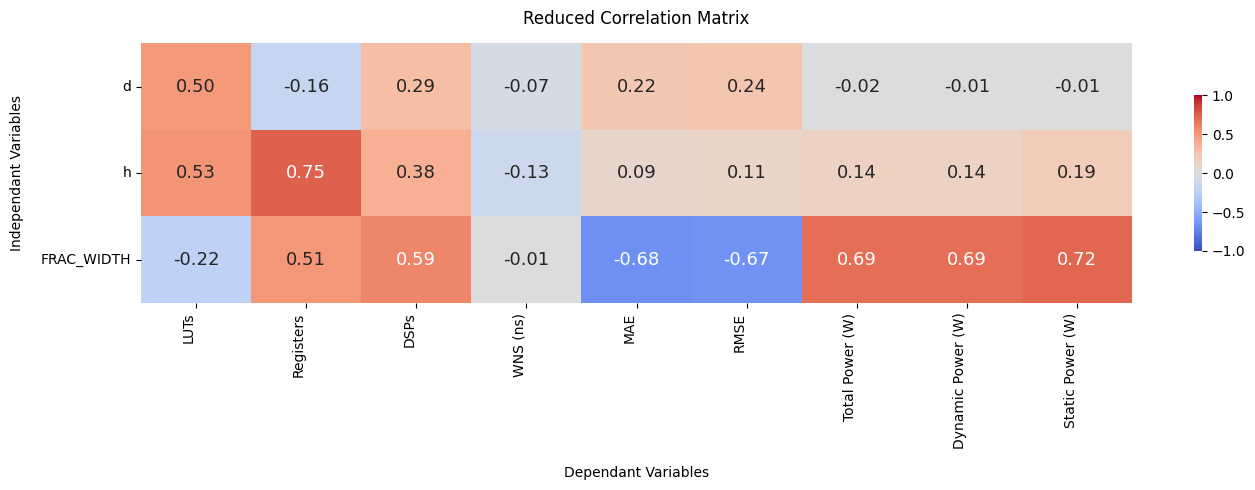

In [8]:
set_bottom = dependant_variables
set_right = independant_variables

A = df[set_right].values
B = df[set_bottom].values

corr = np.corrcoef(A.T, B.T)
corr_mat = corr[:len(set_right), len(set_right):]

corr_df = pd.DataFrame(corr_mat, index=set_right, columns=set_bottom)

# Create figure and axes
fig, ax = plt.subplots(figsize=(14, 5))   # wider figure to fit long x-labels

# Plot heatmap
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    ax=ax,
    cbar_kws={"shrink": 0.6},
    annot_kws={"fontsize": 13}              # reduce annotation font size if crowded
)

# Tweak tick labels so they don't get cut off
ax.set_xlabel("Dependant Variables", labelpad=12)
ax.set_ylabel("Independant Variables", labelpad=12)
ax.set_title("Reduced Correlation Matrix", pad=14)

# Rotate and right-align x tick labels (long names)
plt.xticks(rotation=90, ha="right")
plt.yticks(rotation=0)

# Optionally reduce x tick label font size if still crowded
for tick in ax.get_xticklabels():
    tick.set_fontsize(10)

# Tight layout and save without clipping
plt.tight_layout()
plt.savefig("reduced_corr_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

In [9]:
#sns.pairplot(df)

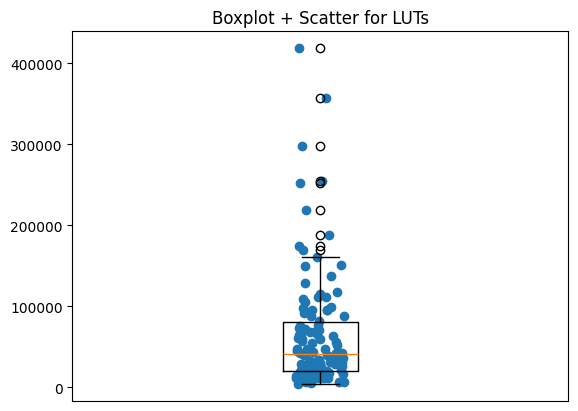

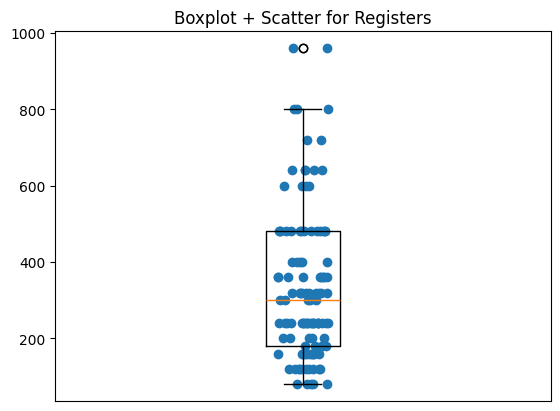

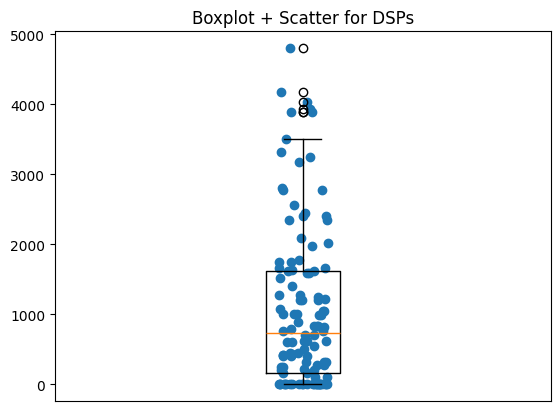

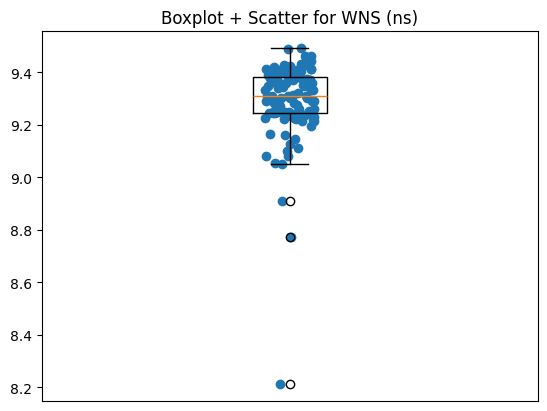

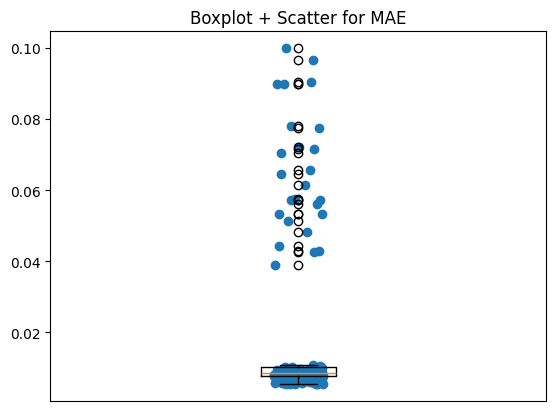

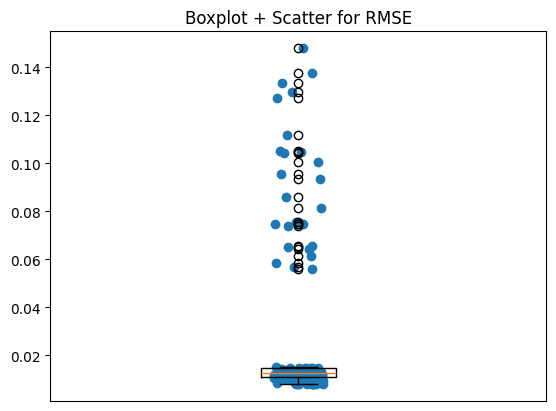

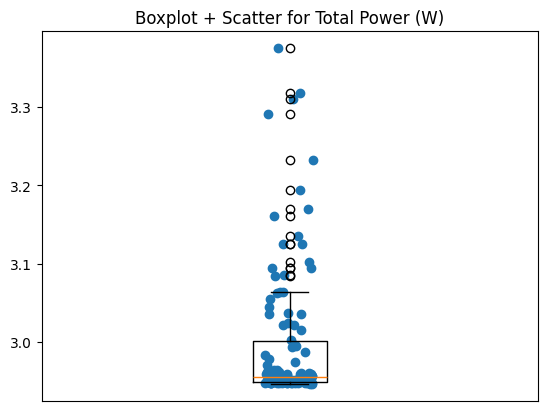

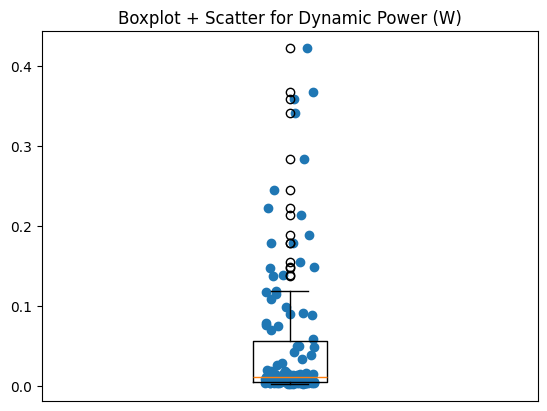

In [10]:
for col in dependant_variables:
    data = df[col].dropna()

    fig, ax = plt.subplots()

    # Boxplot
    ax.boxplot(data, positions=[0])

    # Jitter scatter points so they don't overlap
    jitter = np.random.uniform(-0.05, 0.05, size=len(data))
    ax.scatter(jitter, data)

    # Clean axis labels
    ax.set_title(f"Boxplot + Scatter for {col}")
    ax.set_xticks([])

    plt.savefig(f"boxplot_{col}.png", dpi=300, bbox_inches="tight")

In [ ]:
def generate_equation(X, y, var_names, max_terms=7):
    """
    Generate equation with real-valued exponents for each variable
    Format: y = c0 + c1*x1^p1 + c2*x2^p2 + ... + cn*xn^pn
    """
    n_vars = X.shape[1]
    
    def equation(params):
        """Evaluate equation with given parameters"""
        c0 = params[0]  # constant term
        result = np.full(len(X), c0)
        
        for i in range(n_vars):
            c = params[1 + 2*i]      # coefficient
            p = params[1 + 2*i + 1]  # exponent
            
            # Handle potential numerical issues
            x_vals = X[:, i]
            # Avoid log of zero or negative numbers for non-integer powers
            if np.any(x_vals <= 0):
                x_vals = np.abs(x_vals) + 1e-10
            
            result += c * np.power(x_vals, p)
        
        return result
    
    def objective(params):
        """Objective function to minimize (RMSE)"""
        try:
            pred = equation(params)
            if np.any(np.isnan(pred)) or np.any(np.isinf(pred)):
                return 1e10
            return np.sqrt(mean_squared_error(y, pred))
        except:
            return 1e10
    
    # Set bounds for parameters
    # [c0, c1, p1, c2, p2, ..., cn, pn]
    bounds = [(-100, 100)]  # constant term
    for i in range(n_vars):
        bounds.append((-100, 100))  # coefficient
        bounds.append((-3, 3))      # exponent
    
    # Use differential evolution for global optimization
    result = differential_evolution(objective, bounds, maxiter=1000, 
                                   popsize=15, seed=42, polish=True)
    
    return result.x, equation

In [ ]:
def format_equation(params, var_names, dep_var_name, y_true, y_pred):
    """Format and print the equation with accuracy metrics"""
    n_vars = len(var_names)
    c0 = params[0]
    
    equation_str = f"{dep_var_name} = {c0:.6f}"
    
    for i in range(n_vars):
        c = params[1 + 2*i]
        p = params[1 + 2*i + 1]
        
        sign = " + " if c >= 0 else " - "
        equation_str += f"{sign}{abs(c):.6f} * {var_names[i]}^{p:.6f}"
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    print("=" * 80)
    print(f"EQUATION FOR: {dep_var_name}")
    print("=" * 80)
    print(equation_str)
    print(f"\nAccuracy Metrics:")
    print(f"  MAE:  {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print("=" * 80)
    print()

In [ ]:
def fit_all_equations(df, independent_vars, dependent_vars):
    """Fit equations for all dependent variables"""
    X = df[independent_vars].values
    
    results = {}
    
    for dep_var in dependent_vars:
        if dep_var not in df.columns:
            print(f"Warning: {dep_var} not found in dataframe. Skipping...")
            continue
            
        print(f"Processing: {dep_var}...")
        y = df[dep_var].values
        
        # Remove any rows with NaN values
        mask = ~(np.isnan(X).any(axis=1) | np.isnan(y))
        X_clean = X[mask]
        y_clean = y[mask]
        
        if len(y_clean) == 0:
            print(f"No valid data for {dep_var}. Skipping...")
            continue
        
        # Fit equation
        params, equation_func = generate_equation(X_clean, y_clean, independent_vars)
        
        # Generate predictions
        y_pred = equation_func(params)
        
        # Store results
        results[dep_var] = {
            'params': params,
            'equation_func': equation_func,
            'mae': mean_absolute_error(y_clean, y_pred),
            'rmse': np.sqrt(mean_squared_error(y_clean, y_pred))
        }
        
        # Format and print equation
        format_equation(params, independent_vars, dep_var, y_clean, y_pred)
    
    return results

In [ ]:
def save_equations_to_file(results, independent_vars, filename='equations.txt'):
    """Save all equations to a text file"""
    with open(filename, 'w') as f:
        for dep_var, result_data in results.items():
            params = result_data['params']
            n_vars = len(independent_vars)
            c0 = params[0]
            
            equation_str = f"{dep_var} = {c0:.6f}"
            
            for i in range(n_vars):
                c = params[1 + 2*i]
                p = params[1 + 2*i + 1]
                sign = " + " if c >= 0 else " - "
                equation_str += f"{sign}{abs(c):.6f} * {independent_vars[i]}^{p:.6f}"
            
            f.write("=" * 80 + "\n")
            f.write(f"EQUATION FOR: {dep_var}\n")
            f.write("=" * 80 + "\n")
            f.write(equation_str + "\n")
            f.write(f"\nAccuracy Metrics:\n")
            f.write(f"  MAE:  {result_data['mae']:.6f}\n")
            f.write(f"  RMSE: {result_data['rmse']:.6f}\n")
            f.write("=" * 80 + "\n\n")
    
    print(f"Equations saved to {filename}")

In [ ]:
results = fit_all_equations(df, independant_variables, dependant_variables)

In [ ]:
save_equations_to_file(results, independant_variables)